In [91]:
import numpy as np
import scipy

class abstract_vad:
    def is_speech(self, data, inverse = False):
        pass

class vad:
    class psd_threshold(abstract_vad):
        threshold = 0.0

        def __init__(self, threshold):
            self.threshold = threshold

        def is_speech(self, data, inverse = False):
            X = data
            return (np.average(np.abs(X) ** 2) >= self.threshold if not inverse else
                    np.average(np.abs(X) ** 2) < self.threshold)

    class adaptive_avg_psd(abstract_vad):
        avg = 0
        k: np.uint64 = 0

        def is_speech(self, data, inverse = False):
            X = data

            self.avg += (1 / (self.k + 1)) * (np.average(np.abs(X) ** 2) - self.avg)
            self.k += 1

            return (np.average(np.abs(X) ** 2) >= self.avg if not inverse else
                    np.average(np.abs(X) ** 2) < self.avg) 

In [113]:
import numpy as np

class abstract_spectral_processor():
    def process(self, X):
        pass

# Collection of STSA techniques, all of which are descendants of abstract_spectral_processor.
class stsa:
    # Spectral Subtraction
    class subtraction:
        class simplified_weiss(abstract_spectral_processor):
            a = 0
            k = 0
            vad: abstract_vad = None

            def __init__(self, a, k, vad: abstract_vad):
                self.a = a
                self.k = k
                self.vad = vad

            def process(self, X):
                noise_segments = [self.vad.is_speech(frame, inverse = True) for frame in X]
                D = X[noise_segments]
                E_D = np.average(np.abs(D) ** self.a, axis = 0)

                S_hat_mag = ((np.abs(X) ** self.a) - self.k * E_D)
                S_hat_mag[S_hat_mag < 0] = 0
                S_hat_mag **= (1 / self.a)

                S_hat_phase = np.angle(X)
                S_hat = S_hat_mag * np.exp(1j * S_hat_phase)
                S_hat[noise_segments] *= 0.001

                return S_hat

        class psd(abstract_spectral_processor):
            vad: abstract_vad = None

            def __init__(self, vad: abstract_vad):
                self.vad = vad

            def process(self, X):
                return stsa.subtraction.simplified_weiss(2, 1, self.vad).process(X)

        class boll(abstract_spectral_processor):
            vad: abstract_vad = None

            def __init__(self, vad: abstract_vad):
                self.vad = vad

            def process(self, X):
                return stsa.subtraction.simplified_weiss(1, 1, self.vad).process(X)

        class mle(abstract_spectral_processor):
            vad: abstract_vad = None

            def __init__(self, vad: abstract_vad):
                self.vad = vad

            def process(self, X):
                noise_segments = [self.vad.is_speech(frame, inverse = True) for frame in X]
                D = X[noise_segments]
                E_D = np.average(np.abs(D) ** 2, axis = 0)

                S_hat_mag = (0.5 * np.abs(X)) + (0.5 * (np.abs(X) ** 2)) - np.sqrt(E_D)
                S_hat_phase = np.angle(X)
                S_hat = S_hat_mag * np.exp(1j * S_hat_phase)

                S_hat[noise_segments] *= 0.001

                return S_hat
        
    # Source-Filter
    class filters:
        class generalized_wiener(abstract_spectral_processor):
            alpha = 0
            beta = 0
            vad: abstract_vad = None

            def __init__(self, alpha, beta, vad: abstract_vad):
                self.alpha = alpha
                self.beta = beta
                self.vad = vad

            def process(self, X):
                noise_segments = [self.vad.is_speech(frame, inverse = True) for frame in X]
                D = X[noise_segments]
                E_D = np.average(np.abs(D) ** 2, axis = 0)

                SNR_priori = (np.abs(X) ** 2) / (E_D)

                H = ((SNR_priori) / (1 + self.alpha * SNR_priori)) ** self.beta
                S_hat = H * X
                S_hat[noise_segments] *= 0.001

                return S_hat
            
        class wiener(abstract_spectral_processor):
            vad: abstract_vad = None

            def __init__(self, vad: abstract_vad):
                self.vad = vad

            def process(self, X):
                return stsa.filters.generalized_wiener(1, 1, self.vad).process(X)
        
        class psd(abstract_spectral_processor):
            vad: abstract_vad = None

            def __init__(self, vad: abstract_vad):
                self.vad = vad

            def process(self, X):
                return stsa.filters.generalized_wiener(1, 0.5, self.vad).process(X)

        class mle(abstract_spectral_processor):
            vad: abstract_vad = None

            def __init__(self, vad: abstract_vad):
                self.vad = vad

            def process(self, X):
                return stsa.filters.generalized_wiener(1, 2, self.vad).process(X)

In [ ]:
import numpy as np
import scipy

class abstract_spectral_runner:
    processor: abstract_spectral_processor = None

    def __init__(self, processor):
        self.processor = processor

    def run(self, x):
        pass

class offline_runner(abstract_spectral_runner):
    N = 2048
    M = int(0.25 * N)
    W = np.hanning(N)
    sr = 48000
    sft = scipy.signal.ShortTimeFFT(W, M, fs = sr)

    def __init__(self, processor, N = N, M = M, W = W, sr = sr):
        self.processor = processor

        self.N = N
        self.M = M
        self.W = W
        self.sr = sr

        self.sft = scipy.signal.ShortTimeFFT(W, M, fs = sr)

    def run(self, x):
        X = self.sft.stft(x).T
        X_processed = np.asarray([self.processor.process(frame) for frame in X])
        return self.sft.istft(X_processed.T)
    
class realtime_runner(abstract_spectral_runner):
    N = 2048
    M = int(0.25 * N)
    W = np.hanning(N)

    input_buf = np.zeros(N)
    input_write_idx = 0
    output_buf = np.zeros(M + N)
    output_read_idx = 0
    output_write_idx = 0

    output_block_size = 64

    def __init__(self, processor, N = N, M = M, W = W, output_block_size = output_block_size):
        self.processor = processor
        self.N = N
        self.M = M
        self.W = W
        self.output_block_size = output_block_size

    def run(self, x):
        # Read in x
        to_write = min(len(x), len(self.input_buf) - self.input_write_idx)
        self.input_buf[self.input_write_idx : self.input_write_idx + to_write] = x
        self.input_write_idx += to_write

        # Process when input buffer is full
        if (self.input_write_idx == len(self.input_buf)):
            self.input_write_idx = 0

            # Spectral processing
            X = scipy.fft.fft(self.W * self.input_buf)
            X_processed = self.processor.process(X)
            x_processed = scipy.fft.ifft(X_processed)

            # Writing to circular buffer; overlap-add for first M samples, overwrite for the remainder
            for i in range(len(x_processed)):
                if i < self.M:
                    self.output_buf[(self.output_write_idx + i) % len(self.output_buf)] += x_processed
                else:
                    self.output_buf[(self.output_write_idx + i) % len(self.output_buf)] = x_processed
            
            self.output_write_idx = (self.output_write_idx + len(x_processed)) % len(self.output_buf)

            # If there's some remaining input, write it to the beginning
            if (to_write := len(x) - to_write) > 0:
                self.input_buf[0 : to_write] = x[-1 * to_write]
                self.input_write_idx += to_write

        # Read from output buffer
        output_block = np.zeros(self.output_block_size)
        for i in range(len(self.output_block_size)):
            output_block[i] = self.output_buf[self.output_read_idx + i]

        self.output_read_idx = (self.output_read_idx + self.output_block_size) % len(self.output_buf)

        return output_block
        



/var/folders/cd/jgfs8rys5r98h33wkdxnjfl00000gn/T/ipykernel_99079/723682508.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, x = scipy.io.wavfile.read("noisy_signal.wav")


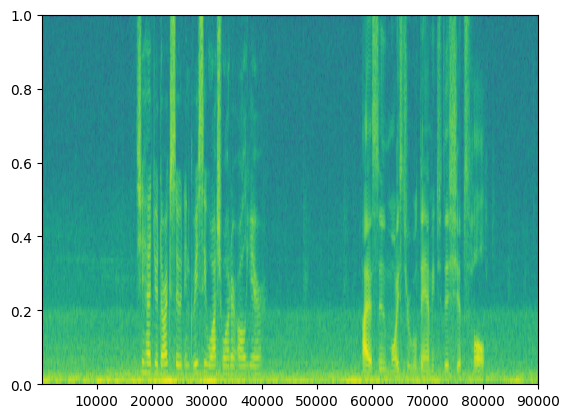

In [ ]:
import IPython
import matplotlib.pyplot as plt
import scipy

sr, x = scipy.io.wavfile.read("noisy_signal.wav")
plt.specgram(x)
plt.show()

IPython.display.Audio(x, rate = sr)

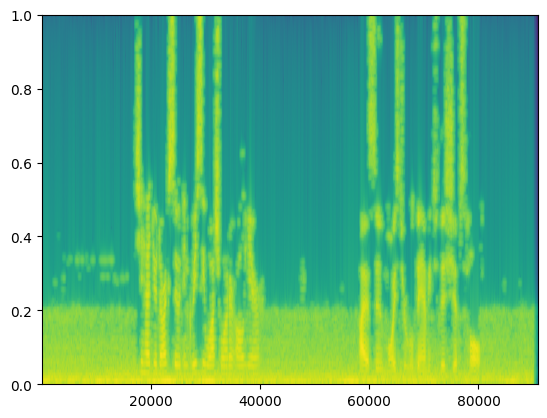

In [116]:
import matplotlib.pyplot as plt

psds = offline_runner(processor = stsa.subtraction.boll(vad = vad.psd_threshold(1e7))).run(x)
plt.specgram(psds)
plt.show()

IPython.display.Audio(psds, rate = sr)

In [ ]:
import pyaudio